In [42]:
from datetime import datetime, timezone
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import double_edge_swap as des

### Generates the synthetic data

In [17]:
number_of_vertices = 100

##### Geometric graph with vertices in a 3D ellipsoid

In [18]:
# Generates a grid of evenly spaced points in the unit cube centered at the origin
number_of_points = 11
x = np.linspace(-0.5, 0.5, number_of_points)
xs = np.array(np.meshgrid(x, x, x))
coordinates = np.transpose(xs.reshape((3,-1)))
coordinates[:, [0, 1]] = coordinates[:, [1, 0]]

# Keeps 'number_of_vertices' points that are within a ellipsoid with semi-axes a, a, c
a, c = 0.3, 0.5
coordinates = coordinates[np.where((coordinates[:, 0] / a) ** 2 + (coordinates[:, 1] / a) ** 2 + (coordinates[:, 2] / c) ** 2 <= 1)[0]]
assert len(coordinates) >= number_of_vertices, "Not enough points in ellipsoid"
coordinates = coordinates[np.random.choice(coordinates.shape[0], number_of_vertices, replace=False)]

# Builds the distance matrix
x = coordinates[:, 0]
y = coordinates[:, 1]
z = coordinates[:, 2]
distance_matrix = np.sqrt(np.square(x - x[:, np.newaxis]) + np.square(y - y[:, np.newaxis]) + np.square(z - z[:, np.newaxis]))

In [19]:
# Creates a graph by connecting points that are within a distance h
h = np.sqrt(2) / number_of_points
adjacency_matrix = (distance_matrix <= h).astype(int)
np.fill_diagonal(adjacency_matrix, 0)
assert np.allclose(adjacency_matrix, adjacency_matrix.T), "Adjacency matrix is not symmetric"

number_of_edges = int(np.sum(adjacency_matrix) / 2)

print('Number of vertices: {}'.format(int(number_of_vertices)))
print('Number of edges: {}'.format(number_of_edges))
print('Average degree: {}'.format(2 * number_of_edges / number_of_vertices))


Number of vertices: 100
Number of edges: 130
Average degree: 2.6


##### Various non-geometric graphs

Not used in the example.

### Generates the shuffled graphs

In [20]:
name = "../data/synthetic/double_edge_swap_example/ellipsoid_{}_V{:04d}_E{:04d}".format(datetime.now(timezone.utc).strftime('%Y%m%d%H%M%S'),
                                                                                        number_of_vertices, 
                                                                                        number_of_edges)
shuffling_levels = np.logspace(-1, 2, 21)
nb_graphs_to_generate_per_shuffling_level = 20
adjacency_matrix_to_shuffle = adjacency_matrix

des.save_graph_to_file(adjacency_matrix_to_shuffle,
                       name + "_I{:06d}_{:04d}_edgelist.csv".format(0, 0),
                       distance_matrix=distance_matrix)

for i, fraction in enumerate(shuffling_levels):

    for j in range(nb_graphs_to_generate_per_shuffling_level):

        shuffled_adjacency_matrix = des.double_edge_swap(adjacency_matrix_to_shuffle,
                                                        number_of_iterations=fraction*number_of_edges,
                                                        distance_matrix=distance_matrix)
        des.save_graph_to_file(shuffled_adjacency_matrix,
                               name + "_I{:06d}_{:04d}_edgelist.csv".format(int(fraction * number_of_edges),
                                                                            i * nb_graphs_to_generate_per_shuffling_level + j),
                               distance_matrix=distance_matrix)


### Plots the average distance between neighbors as a function of number of iterations

In [46]:
rootname = "../data/synthetic/double_edge_swap_example/ellipsoid_20240327195759"

x = []
y = []
for filenames in sorted(glob.glob(rootname + "_*_edgelist.csv")):
    x.append(int(filenames.split("_I")[1][:6]))
    y.append(np.average(pd.read_csv(filenames)["distance"]))

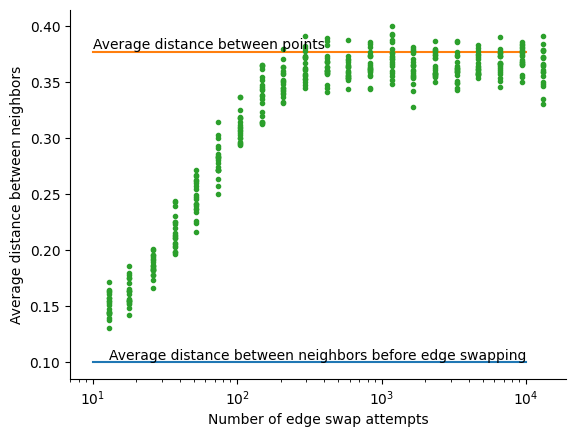

In [51]:
fig, ax = plt.subplots()

average_distance_between_neighbors_before_edge_swapping = np.average(distance_matrix[adjacency_matrix == 1])
ax.plot([1e1, 1e4], [average_distance_between_neighbors_before_edge_swapping, average_distance_between_neighbors_before_edge_swapping])
ax.text(1e4, average_distance_between_neighbors_before_edge_swapping, "Average distance between neighbors before edge swapping", ha="right", va="bottom")

average_distance_between_vertices = np.average(distance_matrix)
ax.plot([1e1, 1e4], [average_distance_between_vertices,average_distance_between_vertices])
ax.text(1e1, average_distance_between_vertices, "Average distance between points", ha="left", va="bottom")

ax.plot(x, y, ls="None", marker="o", markersize=3)

ax.set_xscale("log")

ax.set_xlabel(r"Number of edge swap attempts")
ax.set_ylabel(r"Average distance between neighbors")

sns.despine(ax=ax)